<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 7 (Assignment) -- Generative models II </h2>

# Exercise 0
Before tackling all those exciting tasks of this notebook, the neccessary Python modules need to be loaded. Have a look at the notebook discussed during the lecture, and import the following modules/symbols:

- <code>u7_utils</code>
- <code>matplotlib.pyplot</code>
- <code>matplotlib.image</code>
- <code>numpy</code>
- <code>os</code>
- <code>torch</code>
- <code>torch.autograd.Variable</code>
- <code>types.SimpleNamespace</code>
- <code>typing.Tuple</code>

### Important note!
As the <code>torchvision</code> module used to load data sets does <i>not</i> support version $7$ of the <code>PIL</code> module, ensure that the installed version of your Python environment is from the series $6$. If you are using <i>Anaconda</i> (or <i>Miniconda</i>), you can install the correct version via <code>conda install Pillow==6.2</code>.

In [2]:
try:
    from PIL import __version__
except:
    from PIL import PILLOW_VERSION as __version__

print(r'The installed Pillow version is: {}'.format(__version__))

The installed Pillow version is: 6.2.1


In [3]:
import u7_utils as u7
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import torch
from torch.autograd import Variable
from types import SimpleNamespace
from typing import Tuple

Afterwards, check if the <code>torch</code> module was correctly imported, by computing the <i>cumprod</i> of <code>[7, 2, 4, 9]</code> and printing the result. Moreover, check the version of your <i>PyTorch</i> installation (in case of problems with different Python modules, it is <i>always</i> a good idea to include their <i>version numbers</i> to help others giving a more specific support).

In [4]:
torch.cumprod(torch.as_tensor([7, 2, 4, 9], dtype=torch.float32), dim=0)

tensor([  7.,  14.,  56., 504.])

In [5]:
torch.__version__

'1.3.1+cpu'

As all plots <i>created</i> in this assignment are <i>stored</i> in a specific <i>directory</i>, create a <i>subdirectory</i> termed <code>samples</code> in the current working directory.

In [6]:
if not os.path.exists(os.path.join(r'.', r'samples')):
    os.makedirs(os.path.join(r'.', r'samples'))

# Exercise 1
<font color='darkred'><i>Note: this exercise is pretty similar to <b>Exercise 1</b> of the previous assignment. The reason for this is a simple one: if you are working with a new data set, <b>always</b> get your hands dirty by digging into the structure of the data set itself, visualize different features, try to get a feeling about the data you are working with. Blindly applying methods of Machine Learning to unkown data most often leads to frustrating results.</i></font>

Before loading any <i>data set</i> or defining any <i>neural network</i>, some hyperparameters used throughout this assignment should be set (some entries might be <i>reset</i> in the course of some tasks). Hence, for the <b>first task</b> of this exercise, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters accordingly:

- <code>batch_size = 64</code>
- <code>test_batch_size = 1000</code>
- <code>epochs = 5</code>
- <code>lr = 0.001</code>
- <code>weight_decay = 0.00005</code>

The field <code>log_interval</code> can be chosen freely as well as the <i>device</i> on which to compute.

In [7]:
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=5, lr=0.001,  log_interval=100, weight_decay = 0.00005)
#momentum=0.5, seed=1,
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')


In this exercise you will be working with a data set composed of various <i>images</i> of different kinds of entities (like <i>dogs</i> or <i>ships</i>). For curious minds, more information regarding this data set can be found at (maybe it looks already familiar to you):

<cite>Krizhevsky, A. and Hinton, G., 2009. Learning multiple layers of features from tiny images (Vol. 1, No. 4, p. 7). Technical report, University of Toronto.</cite>

Moreover, perform the following steps prior to unleashing your cumulated knowledge about <i>machine learning</i> on the data:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Load the <i>CIFAR10</i> data set (returns the <i>training</i> as well as the <i>test</i> set data loader).
- Display the first <i>36</i> images of the <i>CIFAR10</i> data set.

Can you identify possible <i>labels</i> of the displayed images?

In [8]:
X = torch.rand(42) 


In [9]:
training_loader, test_loader = u7.get_CIFAR10_data(args, use_cuda)


Files already downloaded and verified
Files already downloaded and verified


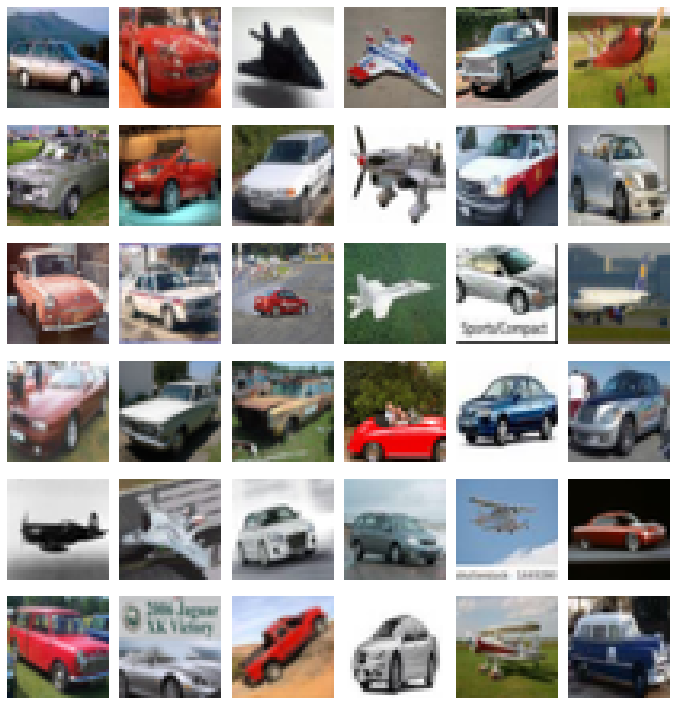

In [10]:
u7.display_FashionMNIST(training_loader, 36)


Yes, I can recognize the labels. They are airplanes and cars.

In order to define any <i>generative</i> neural network (e.g. <i>autoencoders</i> and their various variants) for further processing of the data set, some minimal knowledge about the <i>structure</i> of the images is required:

- Find out the <i>input dimensionality</i> of the data set.

Keep in mind, that images of the CIFAR10 data set are pretty <i>colorful</i>.

In [11]:
image_shape = training_loader.dataset[0][0].shape
input_dim = image_shape[0]*image_shape[1]*image_shape[2]
print(r'The input dimensionality has an amount of: {}'.format(input_dim))


The input dimensionality has an amount of: 3072


More information about the classes and the corresponding target <i>name</i> as well as sample depictions can be found in the following table (images taken from <cite>https://www.cs.toronto.edu/~kriz/cifar.html</cite> and directly embedded, hence an <i>Internet</i> connection is required to load them – only the first <i>two</i> classes are used in this assignment):

| Target   | Name       | Used |Examples                                      |
|:--------:|:----------:|:----:|:---------------------------------------------:|
| 0        | airplane   | X    | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane10.png) |
| 1        | automobile | X    | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile10.png) |
| 2        | bird       |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird10.png) |
| 3        | cat        |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat10.png)        |
| 4        | deer       |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer10.png) |
| 5        | dog        |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog10.png) |
| 6        | frog       |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog10.png) |
| 7        | horse      |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse10.png) |
| 8        | ship       |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship10.png) |
| 9        | truck      |      | ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck1.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck3.png) ![Image not found!](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck10.png) |

As <i>autoencoders</i> (and their variants) are very handy tools for <i>projecting</i> data sets <i>down</i> to a specific dimensionality (often termed <i>compression</i>), a comparison to other established methods is appropriate. For this very purpose, recall your knowledge about <i>dimensionality reduction techniques</i> and perform the following steps as your <b>second task</b> of this exercise:

- Apply <i>PCA</i> on the first $n = 972$ entries and project the CIFAR10 data set down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

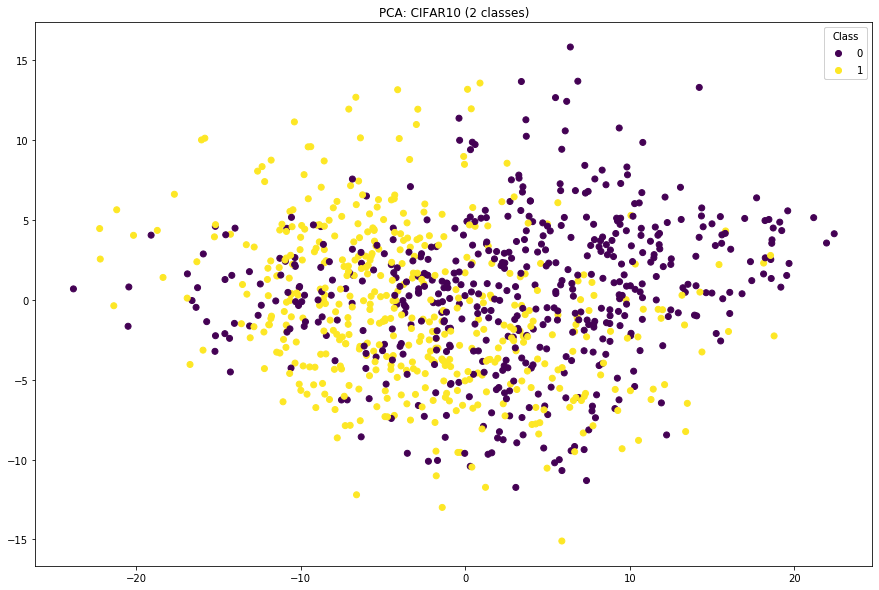

In [12]:
nr_datapoints = 972
u7.plot_PCA(training_loader, 'PCA: CIFAR10 (2 classes)', nr_datapoints)


<i>Principal component analysis</i> is not the only dimensionality reduction technique presented in this course, so to extend the <b>second task</b> of this exercise, further recall your knowledge about this topic (or have a glimpse at the notebooks of the lecture) and perform the following steps:

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the first $n = 972$ entries and project the CIFAR10 data set down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

In [13]:
X_np = np.random.seed(42)


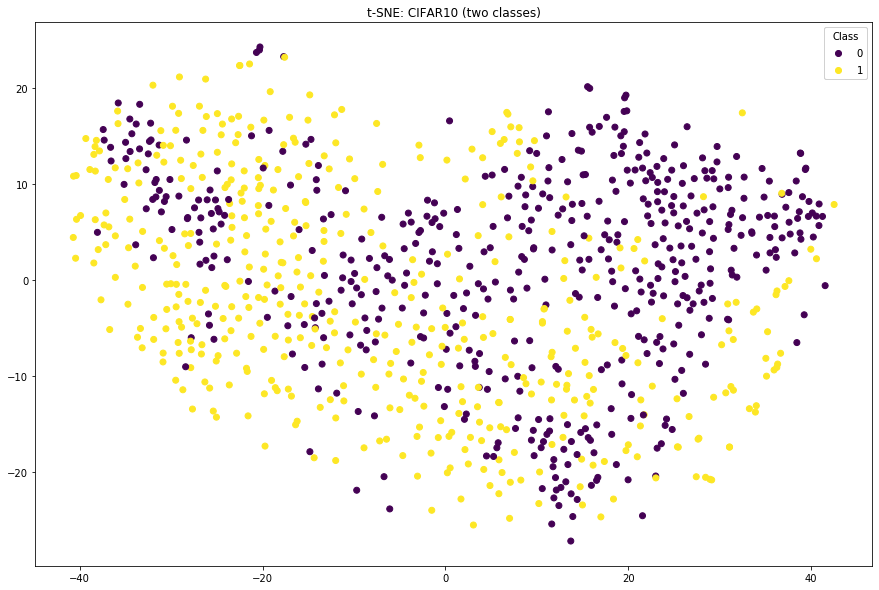

In [14]:
nr_datapoints = 972
u7.plot_tsne(training_loader, 't-SNE: CIFAR10 (two classes)', nr_datapoints)


# Exercise 2
<font color='darkred'><i>Note: the tasks of this exercise will consume <b>a lot</b> of computational resources, and thus will take some time to complete (most probably $\gt 20min$). This is especially the case if <b>no</b> NVIDIA GPU is available. As the final quality of the generated images is highly dependent on the available resources and time spent training the networks, your final points of this exercise will <b>not</b> depend on the image quality but on correctness of the implementation and interpretation of the results.</i></font>

As of <b>Exercise 3</b> of the last assignment, you are already pretty familiar with <i>variational autoencoders</i> and their ability to generate samples from <i>random</i> initial data. As we are again working with images (or more generally, data with <i>structural dependencies</i> between neighboring <i>features</i>), <i>convolutional neural networks (CNNs)</i> seem to be a great fit in order to <i>analyze</i> and <i>transform</i> the data set.

So your <b>first</b> task of this exercise is to combine both methods, <i>variational autoencoders</i> and <i>convolutional neural networks</i>. Thus, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters and further members accordingly $\ldots$

$\ldots$ for the <i>input convolution</i>:
- <code>in_channels = 3</code>
- <code>projection_channels = 32</code>
- <code>input_kernel_size = 3</code>

$\ldots$ for the <i>input pooling</i>:
- <code>input_pool_kernel_size = 2</code>
- <code>input_pool_stride = 2</code>

$\ldots$ for the <i>hidden convolution</i> and <i>mean/covariance projection</i>:
- <code>hidden_channels = 48</code>
- <code>hidden_kernel_size = 3</code>
- <code>input_width = 32</code>
- <code>input_height = 32</code>

$\ldots$ for the <i>hidden pooling</i>:
- <code>hidden_pool_kernel_size = 2</code>
- <code>hidden_pool_stride = 2</code>

Further fields like <code>batch_size</code> or <code>weight_decay</code> can be reused from <b>Exercise 1</b>.

In [15]:
settings = SimpleNamespace(
    
    # Settings of the input convolution.
    input_channels=3, projection_channels=32, input_kernel_size=3,
    
    # Settings of the input pooling.
    input_pool_kernel_size=2, input_pool_stride=2,
    
    # Settings for the hidden convolution and mean/covariance projection.
    hidden_channels=48, hidden_kernel_size=3, input_width=32, input_height=32,
    
    # Settings of the hidden pooling.
    hidden_pool_kernel_size=2, hidden_pool_stride=2
)

On the basis of the <i>convolutional neural network</i> and <i>variational autoencoder</i> implementations of the lecture, construct a <i>convolutional variational autoencoder</i> using the <i>settings</i> defined up above and the following attributes (to get you started, later on you are encouraged to modify some of these settings in order to get more interesting results, but keep in mind, that <i>recklessly</i> setting some hyperparameters to <i>big</i> numbers most probably leads to <i>enormous</i> runtimes) for $\ldots$

$\ldots$ for the <i>encoder</i> network:
- One <i>convolutional</i> input layer, accepting images of the <i>CIFAR10</i> data set.
- One <i>max pooling</i> layer, operating on the result of the <i>input</i> layer.
- One <i>convolutional</i> hidden layer, with an output dimensionality as defined previously.
- One <i>max pooling</i> layer, operating on the result of the <i>hidden</i> layer.
- Two <i>dense</i> encoder layers, with a dimensionality as defined by <code>hidden_channels</code>.
- As the nonlinearity, <i>rectified linear units</i> should be applied (and <i>sigmoid</i> for the decoder output).

$\ldots$ for the <i>decoder</i> network:
- One <i>dense</i> decoder layer, accepting images of the <i>CIFAR10</i> data set, as encoded by the <i>encoder</i> network.
- Two <i>upconvolution</i> layers, effectively transforming the result of the previous layer back to the <i>input</i> space.

To summarize your <b>second task</b> of this exercise:

- Implement a <i>Python class</i> <code>ConvolutionalVAE</code> as discussed during the lexture.
- Implement a <i>utility Python class</i> <code>Inflate</code>, which acts as a negation to <code>Flatten</code>.

In [16]:
import torch.nn as nn
hid_dim = 32
class Inflate(torch.nn.Module):
    
    def __init__(self, dimensionality: int):
        super(Inflate, self).__init__()
        self.__dimensionality = dimensionality
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        #---------------------------------------#
        #               YOUR CODE               #
        return x.view(x.size(0), self.__dimensionality, 8, 8)
        #---------------------------------------#

    
class ConvolutionalVAE(torch.nn.Module):
    def __init__(self, settings: SimpleNamespace):
        super(ConvolutionalVAE, self).__init__()
        
        # Input transformation.
        
        #---------------------------------------#
        #               YOUR CODE               #
        input_convolution = nn.Conv2d(settings.input_channels, settings.projection_channels, 
                               settings.input_kernel_size, padding=1)
        input_pool = nn.MaxPool2d(settings.input_pool_kernel_size)
        hidden_convolution = nn.Conv2d(settings.projection_channels, settings.hidden_channels, 
                               settings.hidden_kernel_size)
        hidden_pool = nn.MaxPool2d(settings.input_pool_kernel_size)
        #---------------------------------------#
        
        # Hidden transformation.
        
        #---------------------------------------#
        #               YOUR CODE               #
        self.dense1 = nn.Linear(settings.hidden_channels*7*7, hid_dim)
        self.dense2 = nn.Linear(settings.hidden_channels*7*7, hid_dim)

        #---------------------------------------#
          
        # Mean and covariance projections.
        
        #---------------------------------------#
        #               YOUR CODE               #
        #---------------------------------------#
        
        # Combine encoder part.
        self.encoder = torch.nn.Sequential(input_convolution, torch.nn.ReLU(), input_pool,hidden_convolution, torch.nn.ReLU(), hidden_pool, torch.nn.Flatten())
        
        # Project from latent space to hidden space of decoder.
        
        #---------------------------------------#
        #               YOUR CODE               #
        latent_projection = nn.Linear(hid_dim, settings.hidden_channels*8*8)
        
        latent_convolution = nn.ConvTranspose2d(settings.hidden_channels, 
                                        settings.projection_channels, 2, stride=2)
        output_convolution = nn.ConvTranspose2d(settings.projection_channels, 
                                        settings.input_channels, 2, stride=2)

        #---------------------------------------#
        
        # Combine decoder part.
        self.decoder = torch.nn.Sequential(
            latent_projection, Inflate(dimensionality=settings.hidden_channels),
            latent_convolution, torch.nn.ReLU(), output_convolution, torch.nn.Sigmoid())
    
    @staticmethod
    def _compute_convolution_size(size: int, padding: int, dilation: int,
                                  kernel_size: int, stride: int) -> int:
        
        #---------------------------------------#
        #               YOUR CODE               #
        return (size+2*padding-kernel_size)/stride + 1
        #---------------------------------------#
    
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        
        #---------------------------------------#
        #               YOUR CODE               #
        x = self.encoder(x)
        return self.dense1(x), self.dense2(x)
        #---------------------------------------#
    
    def decode(self, x: torch.Tensor) -> torch.Tensor:
        
        #---------------------------------------#
        #               YOUR CODE               #
        return self.decoder(x)
        #---------------------------------------#
    
    def sample(self, mean: torch.Tensor, covariance: torch.Tensor) -> torch.Tensor:
        
        #---------------------------------------#
        #               YOUR CODE               #
        if self.training:
            std = torch.exp(0.5*covariance)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)
        else:
            return mean
        #---------------------------------------#
    
    def forward(self, x: torch.Tensor) -> Tuple[
            torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        #---------------------------------------#
        #               YOUR CODE               #
        mean, covariance = self.encode(x)
        x = self.sample(mean, covariance)
        return self.decoder(x), mean, covariance
        #---------------------------------------#
        

Train the previously defined <i>convolutional variational autoencoder</i> model by applying the corresponding <i>data loader</i> (keep in mind for which data set we want the model to be <i>trained</i>) as well as the <i>optimizer</i>.

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.

Report the performance on the <i>test set</i> afterwards. Moreover, experiment with different hyperparameter settings, for instance set different values for $\ldots$

- $\ldots$ the learning rate <code>lr</code>.
- $\ldots$ the hidden dimensionality <code>hidden_channels</code>.
- $\ldots$ the size of the input kernel <code>input_kernel_size</code>.

Do you notice any differences? With respect to runtime, which <i>settings</i> had a small/big impact? Try to argue about <i>possible</i> reasons.

In [17]:
X = torch.rand(42) 


In [18]:
model = ConvolutionalVAE(settings).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

for epoch in range(1, args.epochs + 1):
    u7.train_conv_variational_autoencoder(args, model, device, training_loader, input_dim, optimizer, epoch)
    u7.test_conv_variational_autoencoder(args, model, device, test_loader, input_dim)
    

Train Epoch: 1 [0/10000 (0%)]	Loss: 138568.765625
Train Epoch: 1 [6400/10000 (64%)]	Loss: 120304.148438

Test set loss: 1872404.5000
Train Epoch: 2 [0/10000 (0%)]	Loss: 121432.812500
Train Epoch: 2 [6400/10000 (64%)]	Loss: 114378.031250

Test set loss: 1835149.5625
Train Epoch: 3 [0/10000 (0%)]	Loss: 115793.203125
Train Epoch: 3 [6400/10000 (64%)]	Loss: 117368.367188

Test set loss: 1816008.1250
Train Epoch: 4 [0/10000 (0%)]	Loss: 118148.484375
Train Epoch: 4 [6400/10000 (64%)]	Loss: 115299.351562

Test set loss: 1806705.0625
Train Epoch: 5 [0/10000 (0%)]	Loss: 115798.664062
Train Epoch: 5 [6400/10000 (64%)]	Loss: 113776.031250

Test set loss: 1787779.5625


In the previous exercise, PCA was applied on the <i>input space</i> of the reduced CIFAR10 data set. As a <i>convolutional variational autoencoder</i> model was trained in the meantime, it would be interesting and eventually insightful to analyze the <i>hidden</i> or <i>latent representation</i> of said data set with respect to a distinction between the corresponding <i>targets/classes</i>. The <b>third task</b> of this exercise consists of the following steps:

- Apply <i>PCA</i> on the <i>latent representation</i> of the first $n = 972$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i> (argument <code>input_dim</code> must be of the same shape as an original image of the data set – additionally, the field <code>index</code> has to be $-1$).

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

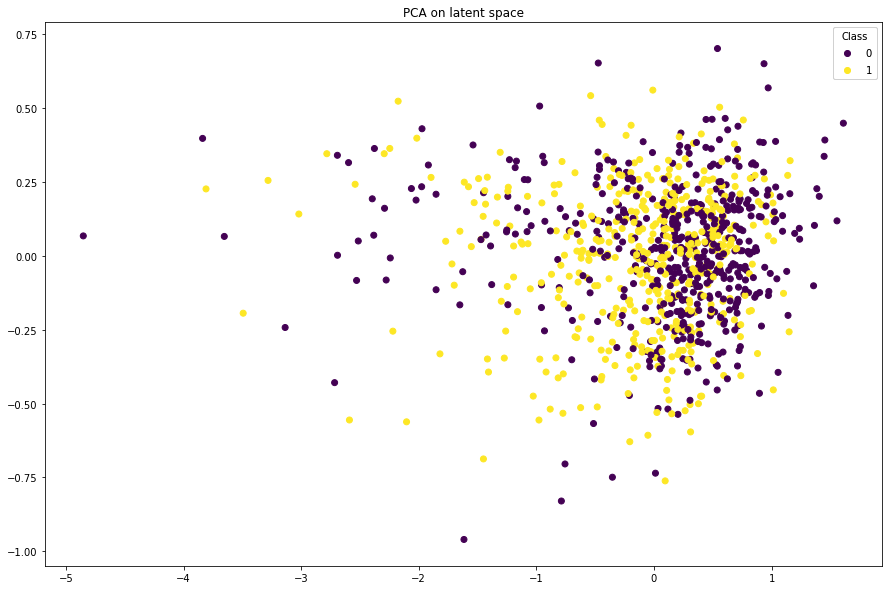

In [19]:
input_dim2 = training_loader.dataset[0][0].shape
u7.plot_PCA_hidden(model, training_loader, device, input_dim2, 'PCA on latent space', 972, -1)


As the results of <i>principal component analysis</i> and <i>t-distributed neighbor embedding</i> might vary a lot, an <i>analysis</i> of the <i>hidden space</i> of your trained <i>convolutional variational autoencoder</i> model on the basis of <i>t-SNE</i> would be very interesting.

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the <i>latent representation</i> of the first $n = 972$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i> (argument <code>input_dim</code> must be of the same shape as an original image of the data set – additionally, the field <code>index</code> has to be $-1$).

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u7_utils.py</code> file).

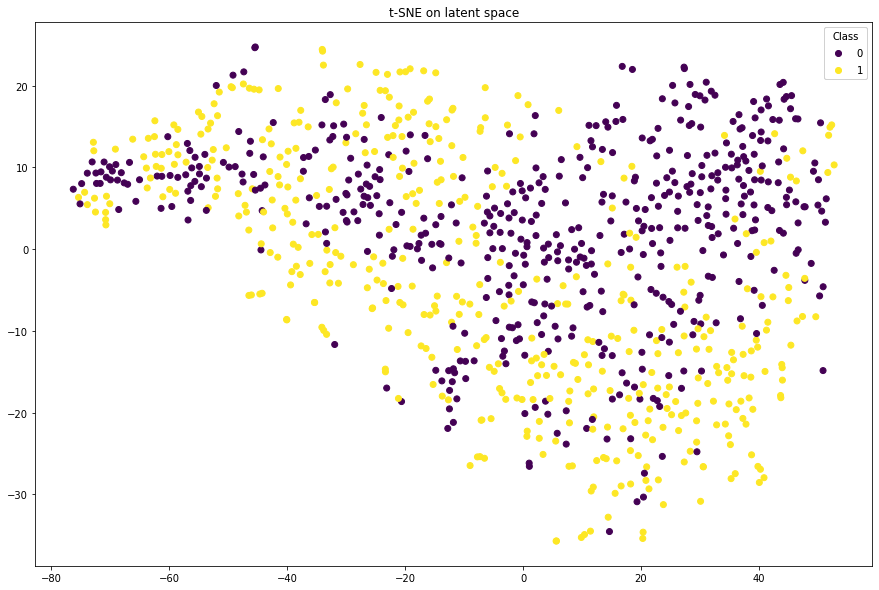

In [20]:
np.random.seed(42)
u7.plot_tsne_hidden(model, training_loader, device, input_dim2, 't-SNE on latent space', 972,-1)


Up until now, the only <i>response</i> of your training procedure were plain <i>numbers</i>. But as you dealing with <i>generative models</i>, actually <i>seeing</i> some of the results might be the <i>actual</i> goal you are aiming for. Therefore, your <b>third</b> and <b>last</b> task of this exercise is defined as:

- Save the <i>decoded</i> latent representation to <code>./samples/vae_random_sample.png</code> (keep in mind to <i>reshape</i> the tensor of the <i>color</i> image accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the <i>lecture</i>).

Do you like what you see? In either case comment on the <i>result</i> and discuss <i>possible</i> shortcomings of <i>variational autoencoders</i> (e.g. with respect to the <i>sharpness</i> of the generated images) and possible <i>pre-processing</i> steps of the data set which might <i>improve</i> the overall model performance.

In [21]:
if not os.path.exists(os.path.join(r'.', r'samples')):
    os.makedirs(os.path.join(r'.', r'samples'))
    

In [22]:
sam = Variable(torch.randn(args.batch_size, 32)).to(device)
output = model.decoder(sam).to(device)
u7.save_image(output.view(args.batch_size, 3, 32, 32),'./samples/u7_image.png')


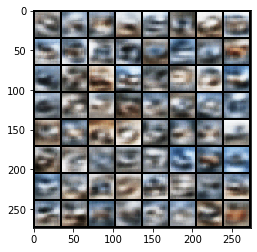

In [23]:
vae_sample = mpimg.imread('./samples/u7_image.png')
plt.imshow(vae_sample)


Do you like what you see? In either case comment on the result and discuss possible shortcomings of variational autoencoders (e.g. with respect to the sharpness of the generated images) and possible pre-processing steps of the data set which might improve the overall model performance.<br><br>
I cannot recognize what items or subjects are in the pictures. The pictures are blurry. The varational autoencoder has the problem that it collapses all dimensions in the latent space which are not needed. Therefore, the outputs are not perfect. Therefore, a GAN could be very useful because the GAN uses the min-max game between generator and discriminator.

# Exercise 3
<font color='darkred'><i>Note: the tasks of this exercise will consume <b>a lot</b> of computational resources, and thus will take some time to complete (most probably $\gt 20min$). This is especially the case if <b>no</b> NVIDIA GPU is available. As the final quality of the generated images is highly dependent on the available resources and time spent training the networks, your final points of this exercise will <b>not</b> depend on the image quality but on correctness of the implementation and interpretation of the results.</i></font>

Before delving into the <i>depths</i> of <i>generative adversarial networks (GANs)</i>, a different data set needs to be loaded, as <i>CIFAR10</i> is a little bit too complex for this exercise. The data set of choice should already look familiar to you:

<cite>Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747</cite>

Moreover, perform the following steps prior to satisfying your curiosity about <i>generative adversarial networks</i> on the data:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Load the <i>Fashion-MNIST</i> data set (returns the <i>training</i> as well as the <i>test</i> set data loader).
- Display the first <i>36</i> images of the <i>Fashion-MNIST</i> data set.

Can you identify possible <i>labels</i> of the displayed images? As you already know the data set inside out, do you observe any <i>differences</i> compared to e.g. the previous assignment?

In [24]:
X2 = torch.rand(42) 


In [25]:
trainL, testL =u7.get_FashionMNIST_data(args, use_cuda)


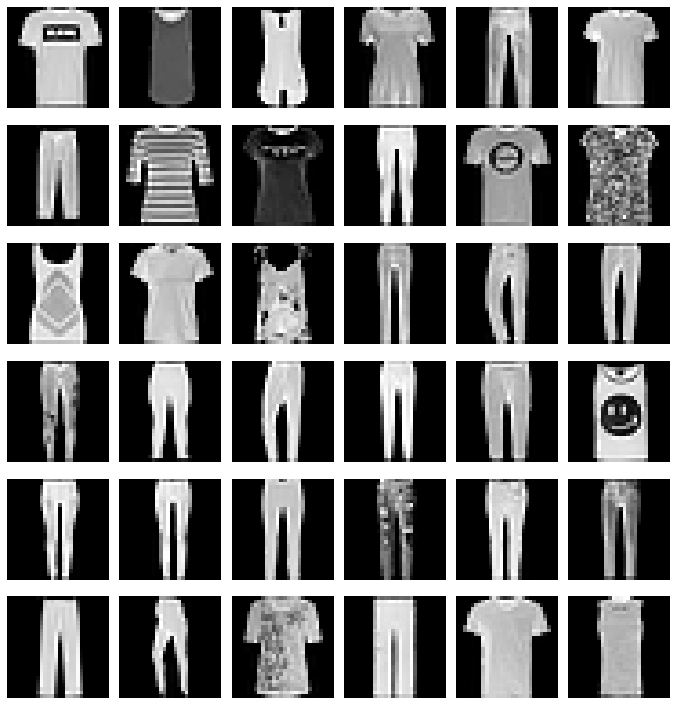

In [26]:
u7.display_FashionMNIST(trainL, 36)
                        

Yes I can recognize the labels. They are trousers and T-shirts. The difference to the assignment before is that here are not more than two labels. 

In order to define <i>generative adversarial network</i> for further processing of the data set (and hopefully generating <i>beautiful</i> images), some minimal knowledge about the <i>structure</i> of the images is required:

- Find out the <i>input dimensionality</i> of the data set.

Keep in mind, that the images of the current data set are <i>less</i> colorful.

In [27]:
image_shape2=trainL.dataset[0][0].shape
input_dim3=image_shape2[0]*image_shape2[1]*image_shape2[2] 
# You can 'image_shape2[0]' leave out.
print(r'The input dimensionality has an amount of: {}'.format(input_dim3))


The input dimensionality has an amount of: 784


After loading and briefly analyzing the Fashion-MNIST data set, you are now getting your hands dirty with <i>generative adversarial networks</i>. So your <b>first</b> task of this exercise is to combine both methods, <i>generative adversarial networks</i> and <i>convolutional neural networks</i>. Thus, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters and further members accordingly $\ldots$

$\ldots$ for the <i>generator</i> network:
- <code>input_channels = 32</code>
- <code>projection_channels = 32</code>
- <code>input_kernel_size = 4</code>
- <code>input_stride = 1</code>
- <code>generator_channels = 64</code>
- <code>generator_kernel_size = 2</code>
- <code>generator_stride = 2</code>
- <code>hidden_dimensionality = 28</code>
- <code>hidden_channels = 1</code>

$\ldots$ for the <i>discriminator</i> network:
- <code>hidden_projection_channels = 48</code>
- <code>hidden_kernel_size = 4</code>
- <code>hidden_stride = 1</code>
- <code>hidden_pool_kernel_size = 4</code>
- <code>hidden_pool_stride = 2</code>
- <code>discriminator_channels = 32</code>
- <code>discriminator_kernel_size = 4</code>
- <code>discriminator_stride = 2</code>
- <code>discriminator_pool_kernel_size = 4</code>
- <code>discriminator_pool_stride = 2</code>

Further fields like <code>batch_size</code> or <code>weight_decay</code> can be reused from <b>Exercise 1</b>.

In [28]:
settings2 = SimpleNamespace(
    
    # Settings of the generator network.
    input_channels=32, projection_channels=48, input_kernel_size=4, input_stride=1,
    generator_channels=64, generator_kernel_size=2, generator_stride=2,
    hidden_dimensionality=28, hidden_channels=1,
    
    # Settings of the discriminator network.
    hidden_projection_channels=48, hidden_kernel_size=4, hidden_stride=1,
    hidden_pool_kernel_size=4, hidden_pool_stride=2,
    discriminator_channels=32, discriminator_kernel_size=4, discriminator_stride=2,
    discriminator_pool_kernel_size=4, discriminator_pool_stride=2
)


On the basis of the <i>convolutional neural network</i> and <i>generative adversarial network</i> implementations of the lecture, construct a <i>convolutional generative adversarial network</i> using the <i>settings</i> defined up above and the following attributes (to get you started, later on you are encouraged to modify some of these settings in order to get more interesting results, but keep in mind, that <i>recklessly</i> setting some hyperparameters to <i>big</i> numbers most probably leads to <i>enormous</i> runtimes) for $\ldots$

$\ldots$ the <i>generator</i> network:
- One <i>upconvolution</i> layer, accepting random inputs of size $1 \times 1$ with channels as defined previously.
- One <i>upconvolution</i> layer defined by <code>generator_*</code> attributes on top of the previous <i>upconvolution</i> layer.
- One <i>dense</i> generator layer, projecting to the <i>target</i> space of the Fashion-MNIST images.
- As the nonlinearity, <i>rectified linear units</i> should be applied (and <i>sigmoid</i> for the generator output).


$\ldots$ the <i>discriminator</i> network:
- One <i>convolutional</i> input layer, accepting images of the <i>Fashion-MNIST</i> data set.
- One <i>max pooling</i> layer, operating on the result of the <i>input</i> layer.
- One <i>convolutional</i> hidden layer, with an output dimensionality as defined previously.
- One <i>max pooling</i> layer, operating on the result of the <i>hidden</i> layer.
- One <i>dense</i> discriminator layer, with a dimensionality suited for <i>binary</i> classification.
- As the nonlinearity, <i>rectified linear units</i> should be applied (and <i>sigmoid</i> for the discriminator output).

To summarize your <b>second task</b> of this exercise:

- Implement a <i>Python class</i> <code>ConvolutionalGenerator</code> as discussed during the lexture.
- Implement a <i>Python class</i> <code>ConvolutionalDiscriminator</code> as discussed during the lexture.
- Implement a <i>utility Python class</i> <code>Inflate</code>, which acts as a negation to <code>Flatten</code>.

In [95]:
class Inflate(torch.nn.Module):
    
    def __init__(self, dimensionality: int):
        super(Inflate, self).__init__()
        self.__dimensionality = dimensionality
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        #---------------------------------------#
        #               YOUR CODE               #
        return x.view(x.size(0), self.__dimensionality, 28, 28)
        #---------------------------------------#

    
class ConvolutionalGenerator(torch.nn.Module):
    
    def __init__(self, settings: SimpleNamespace):
        super(ConvolutionalGenerator, self).__init__()
        
        # Project from input space to hidden space of generator.
        
        #---------------------------------------#
        #               YOUR CODE               #
        input_convolution = nn.ConvTranspose2d(settings2.input_channels, settings2.projection_channels, 
                                        settings2.input_kernel_size)
        generator_convolution = nn.ConvTranspose2d(settings2.projection_channels,
                                            settings2.generator_channels,
                                            settings2.generator_kernel_size, 
                                            settings2.generator_stride)
        hidden_projection = nn.Linear(4096, input_dim3) 
        

        #---------------------------------------#
        
        # Combine the generator.
        self.generator = torch.nn.Sequential(
            input_convolution, torch.nn.ReLU(), generator_convolution, torch.nn.ReLU(),
            torch.nn.Flatten(), hidden_projection,
            Inflate(dimensionality=settings.hidden_dimensionality), torch.nn.Sigmoid())
    
    @staticmethod
    def _compute_upconvolution_size(size: int, padding: int, output_padding: int,
                                    dilation: int, kernel_size: int, stride: int) -> int:
        
        #---------------------------------------#
        #               YOUR CODE               #
        return (size+2*padding-kernel_size)/stride + 1
        #---------------------------------------#
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        #---------------------------------------#
        #               YOUR CODE               #
        x = self.input_convolution(x)
        x = F.relu(x)
        x = self.generator_convolution(x)
        x = F.relu(x)
        x = torch.nn.Flatten(x)
        x = self.hidden_projection(x)
        x = F.Inflate(1) 
        x = F.sigmoid(x)
        return x
        
        #---------------------------------------#

    
class ConvolutionalDiscriminator(torch.nn.Module):
    
    def __init__(self, settings: SimpleNamespace):
        super(ConvolutionalDiscriminator, self).__init__()
        
        # Project from the hidden space to the output space of the discriminator.        
        
        #---------------------------------------#
        #               YOUR CODE               #
        hidden_input_convolution = nn.Conv2d(1, settings2.hidden_projection_channels, 
                                    settings2.hidden_kernel_size)#, settings.hidden_stride)
        hidden_pool = nn.MaxPool2d(settings2.hidden_pool_kernel_size, 
                                   settings2.hidden_pool_stride)
        discriminator_convolution = nn.Conv2d(settings2.hidden_projection_channels,
                                            settings2.discriminator_channels,
                                            settings2.discriminator_kernel_size,
                                            settings2.discriminator_stride)
        discriminator_pool = nn.MaxPool2d(settings2.discriminator_pool_kernel_size,
                                         settings2.discriminator_pool_stride)
        output_projection = nn.Linear(32*4, 1)
        #---------------------------------------#
        
        # Combine the discriminator.
        self.discriminator = torch.nn.Sequential(
            hidden_input_convolution, torch.nn.ReLU(), hidden_pool,
            discriminator_convolution, torch.nn.ReLU(), discriminator_pool,
            torch.nn.Flatten(), output_projection, torch.nn.Sigmoid())
    
    @staticmethod
    def _compute_convolution_size(size: int, padding: int, dilation: int,
                                  kernel_size: int, stride: int) -> int:
        
        #---------------------------------------#
        #               YOUR CODE               #
        return (size+2*padding-kernel_size)/stride + 1
        #---------------------------------------#
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        #---------------------------------------#
        #               YOUR CODE               #
        
        return self.discriminator(x)
        """
        x = self.hidden_input_convolution(x)
        x = F.relu(x)
        x = self.discriminator_convoltion(x)
        x = F.relu(x)
        x = torch.nn.Flatten(x)
        x = F.sigmoid(x)
        """
        #---------------------------------------#

Train the previously defined <i>convolutional generative adversarial network</i> model by applying the corresponding <i>data loader</i> (keep in mind for which data set we want the model to be <i>trained</i>) as well as the <i>optimizer</i>. 

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.

Report the performance on the <i>test set</i> afterwards. Moreover, experiment with different hyperparameter settings, for instance set different values for $\ldots$

- $\ldots$ the learning rate <code>lr</code>.
- $\ldots$ the depth of the random input vector <code>input_channels</code>.
- $\ldots$ the size of the input kernel <code>input_kernel_size</code>.

Do you notice any differences? With respect to runtime, which <i>settings</i> had a small/big impact? Try to argue about <i>possible</i> reasons.

In [96]:
X4 = torch.rand(42)


In [97]:
G = ConvolutionalGenerator(settings2)
D = ConvolutionalDiscriminator(settings2)


In [98]:
criterion = nn.BCELoss()
optim_G = u7.optim.Adam(G.parameters(), lr=args.lr)
optim_D = u7.optim.Adam(D.parameters(), lr=args.lr)


In [99]:
from typing import Iterable
z_latent = 100
def train_discriminator(x, discriminator, generator, input_dim3, batch_size, criterion, z_latent, optim_D, device):
    discriminator.zero_grad()

    # discriminator loss on real
    x_real = x.view(-1, *input_dim3) if isinstance(input_dim3, Iterable) else x.view(-1, input_dim3)
    y_real = torch.ones(x_real.shape[0], 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = discriminator(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # discriminator loss on fake
    z = Variable(torch.randn(
        batch_size, *z_latent if isinstance(z_latent, Iterable) else [z_latent]).to(device))
    x_fake, y_fake = generator(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = discriminator(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()


def train_generator(discriminator, generator, batch_size, criterion, z_latent, G_optimizer, device):
    generator.zero_grad()

    z = Variable(torch.randn(
        batch_size, *z_latent if isinstance(z_latent, Iterable) else [z_latent]).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = generator(z)
    D_output = discriminator(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()


In [100]:
for epoch in range(1, args.epochs+1):           
    D_losses, G_losses = [], []
    for x, _ in trainL:
        D_losses.append(train_discriminator(x, D, G, input_dim3, args.batch_size, criterion, z_latent, optim_D, device))
        G_losses.append(train_generator(D, G, args.batch_size, criterion, z_latent, optim_G, device))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), args.epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    with torch.no_grad():
        test_z = Variable(torch.randn(args.batch_size, z_latent).to(device))
        generated = G(test_z)
        save_image(generated.view(generated.size(0), 1, 28, 28), os.path.join('.','samples','GAN_sample_{}.png'.format(epoch)))

print("Done")


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 48 1 4 4, but got 2-dimensional input of size [64, 784] instead

Why does it not work? I tried to find a solution but could not find anyone. Also, the second version with additional "labels" did not work:

In [103]:
z_latent = 100
def train_C_discriminator(x, discriminator, generator, input_dim3, batch_size, criterion, z_latent, optim_D, device, labels):
    discriminator.zero_grad()

    # discriminator loss on real
    x_real, y_real = x.view(-1, input_dim3), torch.ones(x.view(-1, input_dim3).shape[0])
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    labels = labels.to(device)

    D_output_real = discriminator(x_real, labels)
    #D_real_loss = criterion(D_output_real, Variable(torch.ones(batch_size)).to(device))
    D_real_loss = criterion(D_output_real, y_real)

    # discriminator loss on fake
    z = Variable(torch.randn(batch_size, z_latent).to(device))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    x_fake = generator(z, fake_labels)
    D_output_fake = discriminator(x_fake, fake_labels)
    D_fake_loss = criterion(D_output_fake, Variable(torch.zeros(batch_size)).to(device))

    # gradient backprop
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()


def train_C_generator(discriminator, generator, batch_size, criterion, z_latent, optim_G, device):
    generator.zero_grad()

    z = Variable(torch.randn(batch_size, z_latent).to(device))
    y = Variable(torch.ones(batch_size).to(device))

    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    G_output = generator(z, fake_labels)
    D_output = discriminator(G_output, fake_labels)
    G_loss = criterion(D_output, y)

    # gradient backprop
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()


In [104]:
for epoch in range(1, args.epochs+1):
    D_losses, G_losses = [], []
    for x, y in trainL:
        D_losses.append(train_C_discriminator(x, D, G, input_dim3,args.batch_size, criterion, z_latent, optim_D, device, y))
        G_losses.append(train_C_generator(D, G, args.batch_size, criterion, z_latent, optim_G, device))
        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
        (epoch), args.epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        with torch.no_grad(): 
            test_z = Variable(torch.randn(args.batch_size, 32,1,1).to(device))
            generated = G(test_z)
            u7.save_image(generated.view(generated.size(0), 1, 28, 28), 
                              os.path.join('.','samples','Convolutional_GAN_your_sample_{}.png'.format(epoch)))
print("Done")


TypeError: forward() takes 2 positional arguments but 3 were given

As with the <i>convolutional variational autoencoder</i> of the previous exercise, the <i>actual</i> goal of such a method might be to generate interesting images. To verify (or <i>disconfirm</i>) the <i>generative power</i> of your <i>convolutional generative adversarial network</i>, your <b>third</b> and <b>last</b> task of this exercise is defined as:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Save the <i>decoded</i> latent representation to <code>./samples/gan_random_sample.png</code> (keep in mind to <i>reshape</i> the tensor of the <i>colorless</i> image accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the <i>lecture</i>).

Do you like what you see? In either case comment on the <i>result</i> and discuss <i>possible</i> shortcomings of <i>(vanilla) generative adversarial networks</i> (e.g. with respect to the <i>diversity</i> of the generated images) and possible <i>pre-processing</i> steps of the data set which might <i>improve</i> the overall model performance.

In [105]:
X5 = torch.rand(42)


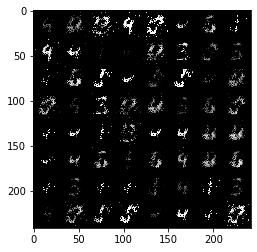

In [106]:
sample_GAN_er = mpimg.imread('./samples/GAN_sample_{}.png'.format(args.epochs))
plt.imshow(sample_GAN_er)


It seems that the training of the neural network was not successful. Therefore, the results are not fine. I cannot recognize any object oder subject.
In general, the performance could be maybe improved by using the conditional GAN. So, you can determine with which class shall be worked first. 